# Image Analysis and Processing Assignment 1

### Import the libraries that will be used for the excercises

In [1]:
from matplotlib import pyplot as plt
from PIL import Image 
import skimage
import cv2
import scipy
import numpy as np
from IPython.display import display # to display images
%matplotlib inline

## Exercise 1.1


### a) 
The transformation function that is given in the assignment is a function that quantizes a greyscale image. Certain ranges of input intensity values are mapped into a certain constant value in the output. For instance, all intensity values from $ 0-30 $ in the input are mapped to the value $ 30 $ in the output. The function quantizes the greyscale image into 8 levels as many as the distinct flat regions in the function graph. An image that undergoes that transformation function will only have 8 different shades of grey in the output. Since the output range of the transformation function is $ [10, 200] $ , this will result in a dimmer image in terms of luminosity, as the many high intensity values are mapped to lower intensity ones in the output. Furthermore, due to the flat regions of the function not being equal in width some shades of gray will be represented more in the output, however this also depends on the initial distribution of the intensity values of the image. 

![](step_fun.png)


### b) 
In order to verify our assumptions about the transformation function we will apply it in an image in the cell below and show the image before and after the transformation.

The image before the transformation: 


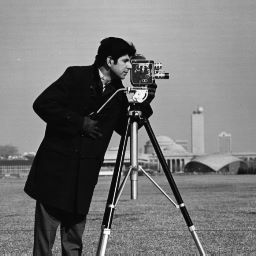

The image after the transformation: 


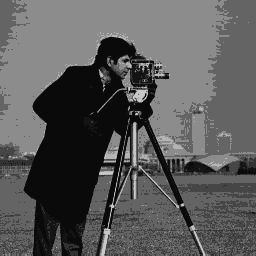

In [8]:
def my_transform(img):
    img = np.asarray(img)
    ini_shape = img.shape
    img.reshape(-1)
    img = np.piecewise(img,
                       [img <= 30, (img > 30) & (img <= 60), (img > 60) & (img <= 90),
                        (img > 90) & (img <= 120), (img > 120) & (img <= 160),
                        (img > 160) & (img <= 190), (img > 190) & (img <= 220),
                        (img > 220) & (img <= 255)],
                       [10, 20, 50, 70, 100, 140, 180, 200])
    img = Image.fromarray(np.uint8(img).reshape(ini_shape))
    return img

img = Image.open("cameraman.jpg").convert("L")
print("The image before the transformation: ")
display(img)
print("The image after the transformation: ")
display(my_transform(img))

## Exercise 1.2

In this excercise we are asked to try and improve the perceived light and color of the image "nature_dark_forest.png". Our first thought was the application of a basic pixelwise linear transformation $$ y = \alpha \cdot x $$ where $ \alpha $ is a user defined constant. If $ \alpha > 1 $ then the transformation will result in a increasing the intensity of each pixel. Also, since we are applying a linear function the absolute increase in intensity will be much more significant on pixels that had high intensity in the original image, this results in an increase in the contrast between the original intensity values.
By applying this transformation to each color channel of the image in the cell below, we can observe that as the constant $ \alpha $ increases the image gets brighter and the colours look more vibrant. However, as the value of $ \alpha $ keeps increasing more and more pixels get clipped at the maximum intesity of $ 255 $ resulting in the loss of detail in the bright areas.

We also tried to perform another point operation called Gamma Correction. Since the human eye perceives changes in the darker intensities than in the bright ones so using a non-linear function that boosts the lower values more than the high ones seems like a promising approach. In order to apply this transformation the image needs to be rescaled from $ [0, 255] $ to floating point numbers between $ [0,1] $. Afterwards the gamma correction function is applied per-pixel and per-channel (since we have an RGB image): $$ y = x^{(1 / \gamma)} $$ 
Finally, the image is rescaled to the original range $ [0, 255] $. As we can see in the results from the code cell bellow values of $\gamma < 1$ make the image darker and $ \gamma > 1$ makes the image brighter. As we expected due to the non-linearity of the function the darker regions get more illuminated than the brighter. This results in better preservation of the details in the brighter regions as $ \gamma $ increases.

After, experimentation and visual inspection of the results. We can see that the best results are obtained for $\alpha \approx 1.42 $ and $ \gamma \approx 1.37 $ for the two respective methods. The output of the first transformation with $ \alpha \approx 1.42 $ seems to be the best visually since it makes the image brighter and the colors more vivid.


In [ ]:
import math

def adjust_gamma(image, gamma=1.3):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

img = cv2.imread('nature_dark_forest.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle("Multiplication with a constant alpha", fontsize = 16)
alphas = np.linspace(1, 2.5, 8)
plt.subplot(3, 3, 1)
plt.title(f"Original")
plt.imshow(img)
plt.axis('off')
for i, a in enumerate(alphas):
    plt.subplot(3, 3, i + 2)
    adjusted_img = cv2.addWeighted(img,a,np.zeros(img.shape, img.dtype),0,0)
    plt.title(f"Alpha = {a}")
    plt.imshow(adjusted_img)
    plt.axis('off')


fig, axes = plt.subplots(3, 3, figsize=(20,15))
fig.suptitle("Gamma correction", fontsize = 16)
gammas = np.linspace(0.5, 2, 8)
plt.subplot(3, 3, 1)
plt.title(f"Original")
plt.imshow(img)
plt.axis('off')

for i, g in enumerate(gammas):
    plt.subplot(3, 3, i + 2)
    adjusted_img = adjust_gamma(img, g)
    plt.title(f"Gamma = {g}")
    plt.imshow(adjusted_img)
    plt.axis('off')

## Exercise 1.3

Simillary to the previous excercise we are asked to enhance the brightness of an image, this time the greyscale image "pollen-500x430px-96dpi.jpg". A method that we saw we saw in our course is the Histogram Equalization. Considering that we have an image that the majority of the pixels lie at the darker tonal levels this method that tries to transform the image so that it captures the full tonal range will brighten it and improve the contrast. Histogram Equalization works by creating a histogram for each intensity level, using that histogram to calculate the Cumulative Density Function and with that to create a transformation function:
$$ T_{k} = \text{floor} \left((L-1) \sum_{n=0}^k p_n \right ) , \text{where: } p_n= \frac {\text{number of pixels with intensity n }} {\text{total number of pixels}}$$

The application of that transformation function results in "streching" the histogram of the intensity values to caputre the full tonal range. We should also note that an advantage of this method is that it needs no user defined parameters for its application, se there is no need for parameter tuning.

By running the code cell below, the original image and histogram as well as the resulting ones can be seen. The image after that transformation looks much brighter and clear. The intensity values are no longer confined only in the lower intensity range but are now capturing a much wider range.

In [ ]:
img = cv2.imread('pollen-500x430px-96dpi.jpg', 0)


hist, bins = np.histogram(img.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

fig, axes = plt.subplots(1, 2, figsize=(13,5))

plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'center right')
plt.show()



cdf_m = np.ma.masked_equal(cdf,0) 
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf2 = np.ma.filled(cdf_m,0).astype('uint8')

img2 = cdf2[img]

fig, axes = plt.subplots(1, 2, figsize=(13,5))

plt.subplot(121)
plt.imshow(img2, cmap='gray')
plt.title('Image after Histogram equalization')
plt.axis('off')

plt.subplot(122)
plt.plot(cdf2, color = 'b')
plt.hist(img2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'center right')
plt.show()

## Exercise 1.4

In this excercise we are going to tackle the task of sharpening an image. In order to do that and after trying various methods, the one that had the best visual results in our opinion is the one we are implementing in the code cell below. After some research online, a widely used process of sharpening an image is the addition of the following: Convolving the original image with the negative Laplacian filter and then adding the resulting image back to the original image. This works because the negative Laplacian filter is a high-pass filter and convolving it with the original image will result in an image that preserves the high frequences (areas with high amount of change between the pixels, the "details"). Then, adding that image back to the original will result in boosting the intensities of those pixels that present the details.

The operation described above can be done by convolving the original image with a single filter:

$$ K = \begin{bmatrix} -1 & -1 & -1 \\ -1 & 9 & -1 \\ -1 & -1 & -1 \end{bmatrix} $$

That filter is the result of adding the negative Laplacian filter to the Identity filter:

$$ K = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0 \end{bmatrix} + \begin{bmatrix} -1 & -1 & -1 \\ -1 & 8 & -1 \\ -1 & -1 & -1 \end{bmatrix} $$

In [ ]:
img = cv2.imread('First-photo-of-the-moon-from-Chandrayaan-2_ISRO.jpg', 0)

plt.figure(figsize=(15,13))
plt.title(f"Original")
plt.imshow(img, "gray")
plt.axis('off')

kernel = -np.ones((3,3),np.float32)
kernel[1,1] = 9

plt.figure(figsize=(15,13))
adjusted_img = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_CONSTANT)
plt.title(f"Sharpened Image")
plt.imshow(adjusted_img, "gray")
plt.axis('off')
plt.show()